<a href="https://colab.research.google.com/github/zezeko/tf_specialization/blob/master/time_series/S%2BP_Week_4_Lesson_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 35kB/s 
     |████████████████████████████████| 3.8MB 44.0MB/s 
     |████████████████████████████████| 450kB 62.0MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-02-17 12:05:32--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.128, 2a00:1450:4013:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0s      

2020-02-17 12:05:32 (145 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



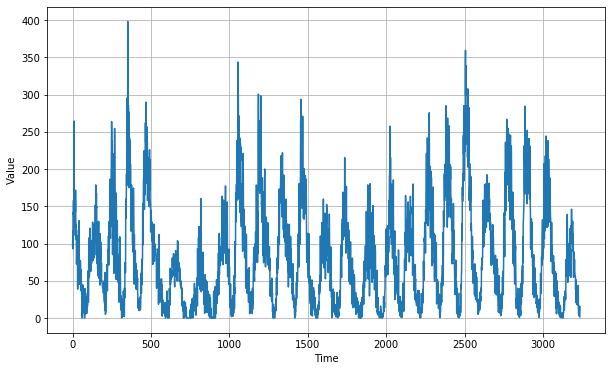

In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

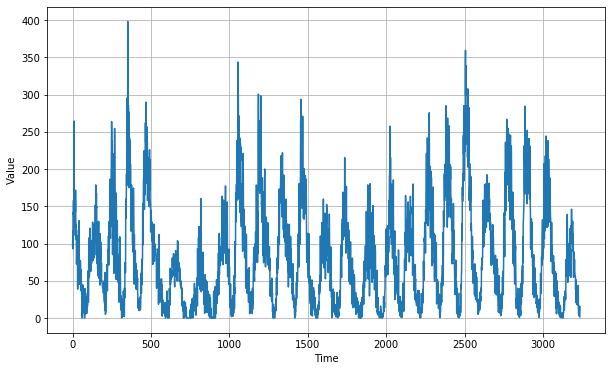

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 7s 601ms/step - loss: 80.3072 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 4s 345ms/step - loss: 77.9405 - mae: 78.5896
Epoch 3/100
12/12 [==============================] - 4s 367ms/step - loss: 75.2415 - mae: 75.9445
Epoch 4/100
12/12 [==============================] - 4s 342ms/step - loss: 72.2421 - mae: 72.7693
Epoch 5/100
12/12 [==============================] - 4s 375ms/step - loss: 68.5302 - mae: 69.2661
Epoch 6/100
12/12 [==============================] - 4s 353ms/step - loss: 64.8655 - mae: 65.6140
Epoch 7/100
12/12 [==============================] - 4s 351ms/step - loss: 61.1551 - mae: 62.0189
Epoch 8/100
12/12 [==============================] - 4s 336ms/step - loss: 58.2311 - mae: 58.6465
Epoch 9/100
12/12 [==============================] - 4s 340ms/step - loss: 54.7059 - mae: 55.5682
Epoch 10/100
12/

[1e-08, 0.0001, 0, 60]

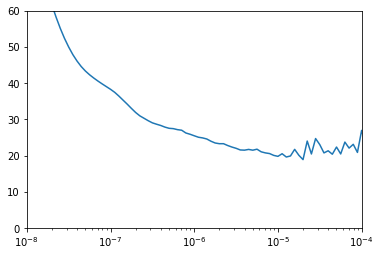

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 6s 200ms/step - loss: 37.8898 - mae: 38.6062
Epoch 2/500
30/30 [==============================] - 3s 114ms/step - loss: 24.1475 - mae: 24.6120
Epoch 3/500
30/30 [==============================] - 4s 120ms/step - loss: 22.0302 - mae: 22.5219
Epoch 4/500
30/30 [==============================] - 3s 112ms/step - loss: 19.8086 - mae: 20.3076
Epoch 5/500
30/30 [==============================] - 3s 114ms/step - loss: 19.4410 - mae: 19.9362
Epoch 6/500
30/30 [==============================] - 4s 117ms/step - loss: 19.2319 - mae: 19.7210
Epoch 7/500
30/30 [==============================] - 3s 116ms/step - loss: 18.5868 - mae: 19.0940
Epoch 8/500
30/30 [==============================] - 3s 115ms/step - loss: 18.4305 - mae: 18.9058
Epoch 9/500
30/30 [==============================] - 4s 118ms/step - loss: 18.1673 - mae: 18.6695
Epoch 10/500
30/30 [==============================] - 4s 117ms/step - loss: 18.1389 - mae: 18.6691
Epoch 11/500
30/30 

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

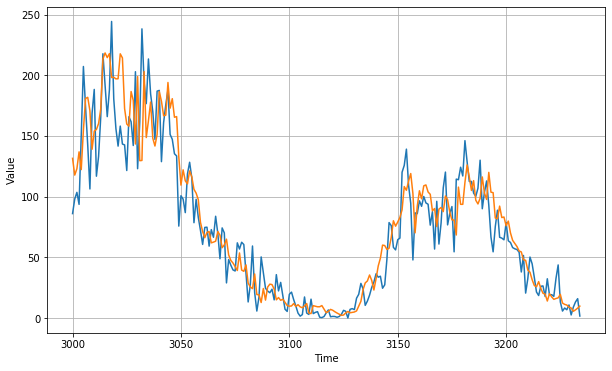

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

16.617907

<Figure size 432x288 with 0 Axes>

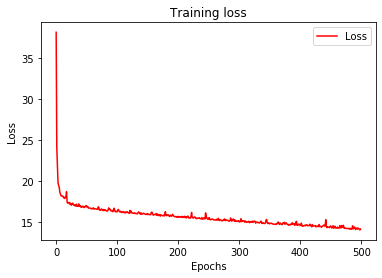

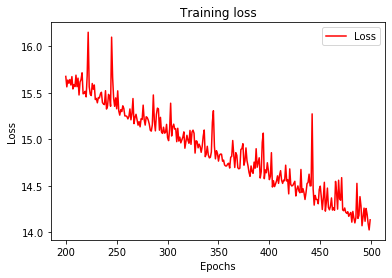

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [16]:
print(rnn_forecast)

[131.51814   117.72813   122.9719    136.87202   122.246346  154.8935
 180.82234   181.79874   170.78622   139.01437   153.94348   155.30966
 160.20395   172.20854   213.31833   218.36996   214.53159   217.81306
 198.10516   198.36859   196.98346   197.11443   217.63684   214.2741
 172.55481   159.81995   158.03899   186.58914   179.23108   143.33284
 198.8718    129.59769   129.77478   203.0119    148.64838   162.51677
 177.88808   148.16765   141.68166   151.19795   186.56967   178.58226
 166.62753   167.14627   194.02168   172.87616   180.69002   165.38187
 165.93843   132.84492   109.457245  122.049095  113.01344   110.450386
 121.16159   116.28719   106.00023   102.854515   97.46229    78.82018
  71.179985   66.1443     70.49503    71.21286    61.903942   62.502296
  63.239265   71.2542     68.15759    57.888447   60.202705   64.92424
  51.967613   47.439182   45.274277   42.322746   39.11618    53.586006
  39.44807    38.443123   43.694794   28.71229    25.615019   24.149307
  36